# README
Run this notebook to create the dataset for mosaic training.

In [1]:
from torch.utils.data import Dataset as BaseDataset

import utils
import albumentations as albu
from albumentations.pytorch.transforms import ToTensorV2

import copy
import random
import time
import os
from functools import wraps

import torch
from pathlib import Path
import numpy as np
from numpy.linalg import LinAlgError
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from einops import rearrange, repeat

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from tqdm import tqdm
import logging

from skimage import morphology

np.random.seed(42)
random.seed(42)

In [2]:
def show_mask(image):
    palette = [
        0, 64, 128,  # r, g, b for Tumor
        64, 128, 0,  # r, g, b for Stroma
        243, 152, 0,  # r, g, b for Normal
        255, 255, 255,  # r, g, b for background
    ] + [0] * 252 * 3
    image = Image.fromarray(np.uint8(image), mode='P')
    image.putpalette(palette)
    plt.imshow(image)
    plt.show()
    plt.close()
    
def show_background(image):
    plt.imshow(image, vmin=0, vmax=127, cmap='gray')
    plt.show()
    plt.close()

def show_image(image):
    if isinstance(image, torch.Tensor):
        image = rearrange(image, 'c h w -> h w c')
    plt.imshow(image)
    plt.show()
    plt.close()

def create_data(train_data):
    print(train_data)
    tumor_set, stroma_set, normal_set = set(), set(), set()
    for path in Path(train_data).glob('*.png'):
        if utils.is_tumor(path): tumor_set.add(str(path))
        if utils.is_stroma(path): stroma_set.add(str(path))
        if utils.is_normal(path): normal_set.add(str(path))

    tumor_images = list(tumor_set - stroma_set - normal_set)
    stroma_images = list(stroma_set - tumor_set - normal_set)
    normal_images = list(normal_set - tumor_set - stroma_set)

    return tumor_images, stroma_images, normal_images

In [3]:

def get_background(region):
    gray = cv2.cvtColor(region, cv2.COLOR_RGB2GRAY)
    ret, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    binary = np.uint8(binary)    
    dst = morphology.remove_small_objects(binary==255,min_size=50,connectivity=1)
    mask = np.array(dst, dtype=np.uint8)
    mask = mask * 255
    return mask


In [4]:
def timeit(fn):
    """decorator for timing functions"""
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = time.time()
        result = fn(*args, **kwargs)
        t2 = time.time()
        logging.info(f"@timefn: {fn.__name__} took {t2 - t1: .5f} s")
        return result
    return measure_time

def visualize(save=None, **images):
    """PLot images in one row."""
    fontsize=14
    def axarr_show(axarr, image, name):
        if isinstance(image, torch.Tensor):
            if image.ndim == 3: image = image.permute(1, 2, 0)
            if image.is_cuda: image = image.detach().cpu().numpy()
        if name == 'mask': 
            palette = [0, 64, 128, 64, 128, 0, 243, 152, 0, 255, 255, 255] + [0] * 252 * 3
            image = Image.fromarray(np.uint8(image), mode='P')
            image.putpalette(palette)
            axarr.imshow(image)
            axarr.set_title(name, fontsize=fontsize)
        elif 'background' in name:
            palette = [255, 255, 255, 0, 0, 0]
            image = Image.fromarray(np.uint8(image), mode='P')
            image.putpalette(palette)
            axarr.imshow(image)
            axarr.set_title(name, fontsize=fontsize)
        else:
            axarr.imshow(image)
            axarr.set_title(name, fontsize=fontsize)
    n = len(images)
    fig, axarr = plt.subplots(nrows=1, ncols=n, figsize=(8, 8))
    if n == 1:
        name, image = list(images.items())[0]
        axarr_show(axarr, image, name)
        axarr.set_yticks([])
        axarr.set_xticks([])
    else:
        for i, (name, image) in enumerate(images.items()):
            axarr_show(axarr[i], image, name)
            
        for ax in axarr.ravel():
            ax.set_yticks([])
            ax.set_xticks([])
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    else:
        plt.show()
    plt.close()

# Plot Train Image and Background

In [5]:

if True: # Set to True for first time runing the script
    train_dir = Path("./data/WSSS4LUAD/1.training")
    train_image_list = sorted(list(train_dir.glob('*.png')))

    background_save_dir = Path("./data/WSSS4LUAD/1.training/background-mask")
    background_save_dir.mkdir(exist_ok=True, parents=True)
    for train_image in tqdm(train_image_list):
        train_image_data = np.array(Image.open(str(train_image)))
        background_data = get_background(train_image_data)
        background_data[background_data > 0] = 1

        palette = [0, 0, 0, 255, 255, 255]
        background_mask = Image.fromarray(np.uint8(background_data), mode='P')
        background_mask.putpalette(palette)

        background_mask.save(str(background_save_dir / train_image.name))

        # blended = np.array(train_image_data)
        # blended[background_data > 0] = [0, 0, 0]
        
        # visualize(image=train_image_data, background=background_data, blended=blended, save=str(Path('data/temp_train_background') / train_image.name))


100%|██████████| 10091/10091 [00:44<00:00, 224.83it/s]


In [6]:
assert len(os.listdir('./data/WSSS4LUAD/1.training/background-mask')) == len(os.listdir('./data/WSSS4LUAD/1.training/')) - 1

----

In [7]:
class CropAndConcatDataset(BaseDataset):    
    def __init__(self, args, patch_num, patch_size, size=None):
       
        self.args = args
        self.train_dir = args.train_dir
        self.train_images = list(Path(self.train_dir).glob('*.png'))
        self.tumor_images, self.stroma_images, self.normal_images = create_data(self.train_dir)

        self.patch_num = patch_num
        self.patch_size = patch_size

        self.total_len = len(self.tumor_images) + len(self.stroma_images) + len(self.normal_images) if size is None else size

        self.crop_fn = albu.Compose([
            # albu.Resize(self.patch_num*self.patch_size, self.patch_num*self.patch_size),
            albu.PadIfNeeded(min_height=self.patch_size, min_width=self.patch_size),
            albu.RandomCrop(width=self.patch_size, height=self.patch_size)
        ])
        
        self.transform = albu.Compose([
            albu.Flip(),
            albu.RandomRotate90(),
        ])
    
    def __getitem__(self, i):
        np.random.seed(2022 + 2022 * i)
        random.seed(2022 + 2022 * i)
        
        H = W = self.patch_num * self.patch_size
        
        while True:
            try:
                normal_image = np.random.rand() < 0.5
                (image_1, mask_1), (image_2, mask_2), (image_3, mask_3), (image_4, mask_4) = [self.create_one_image(normal_image) for _ in range(4)] # [H, W, C]
                image, mask = self.create_mosaic(H, W, image_1, mask_1, image_2, mask_2, image_3, mask_3, image_4, mask_4)
                break            
            except AssertionError as e:
                print(e)

        
        return image, mask

    def create_one_image(self, normal_image):      
        H = W = self.patch_num * self.patch_size
        image = np.zeros((H, W, 3), dtype=np.uint8)
        mask = np.zeros((H, W), dtype=np.uint8)
        # boarder_mask = np.zeros((H, W), dtype=np.uint8)

        for i in range(self.patch_num):
            for j in range(self.patch_num):
                while(True):
                    tile_name = np.random.choice(self.normal_images + self.stroma_images + self.tumor_images)
                    assert sum(utils.to_list(utils.get_label(tile_name))) == 1

                    tile = np.array(Image.open(tile_name))
                    label = utils.to_list(utils.get_label(tile_name)).index(1)
                    tile_mask = np.full((tile.shape[0], tile.shape[1]), label)
                    background_mask = np.array(Image.open(Path(self.train_dir) / 'background-mask' / Path(tile_name).name))
                    tile_mask[background_mask > 0] = 3

                    sample = self.crop_fn(image=tile, mask=tile_mask)
                    tile = sample['image']
                    tile_mask = sample['mask']

                    # Background area is smaller than 80%
                    if np.sum(tile_mask[tile_mask == 3]) < self.patch_size * self.patch_size * 0.8:
                        break
                
                image[i*self.patch_size: (i+1)*self.patch_size, j*self.patch_size: (j+1)*self.patch_size] = tile
                mask[i*self.patch_size: (i+1)*self.patch_size, j*self.patch_size: (j+1)*self.patch_size] = tile_mask

        
        return image, mask
    
    def create_mosaic(self, H, W, image_1, mask_1, image_2, mask_2, image_3, mask_3, image_4, mask_4):
        def get_transforms(height, width, p=0.5):
            _transform = [
                albu.Flip(p=p),
                albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=p),
                albu.RandomCrop(height, width),
            ]
            return albu.Compose(_transform)
        
        image = np.zeros((H, W, 3), dtype=np.uint8)
        mask = np.zeros((H, W), dtype=np.uint8)
        # boarder_mask = np.zeros((H, W), dtype=np.uint8)

        h, w = int(H * (random.random()*0.6+0.2)), int(W * (random.random()*0.6+0.2))
        h += h % 2
        w += w % 2

        transform_1 = get_transforms(height=h, width=w, p=0.8)
        sample = transform_1(image=image_1, mask=mask_1)
        image_1, mask_1 = sample['image'], sample['mask']

        transform_2 = get_transforms(height=h, width=W-w, p=0.8)
        sample = transform_2(image=image_2, mask=mask_2)
        image_2, mask_2 = sample['image'], sample['mask']

        transform_3 = get_transforms(height=H-h, width=w, p=0.8)
        sample = transform_3(image=image_3, mask=mask_3)
        image_3, mask_3 = sample['image'], sample['mask']

        transform_4 = get_transforms(height=H-h, width=W-w, p=0.8)
        sample = transform_4(image=image_4, mask=mask_4)
        image_4, mask_4 = sample['image'], sample['mask']

        # boarder_mask[h-2:h+3, 0:W] = 1
        # boarder_mask[0:H, w-2:w+3] = 1
        
        image[:h, :w, :] = image_1
        image[:h, w:W, :] = image_2
        image[h:H, :w, :] = image_3
        image[h:H, w:W, :] = image_4

        # image_blur = cv2.GaussianBlur(image, (11, 11), 0)
        # image[boarder_mask > 0] = image_blur[boarder_mask > 0]
    
        mask[:h, :w] = mask_1
        mask[:h, w:W] = mask_2
        mask[h:H, :w] = mask_3
        mask[h:H, w:W] = mask_4
        
        return image, mask

    def __len__(self):
        return self.total_len

In [8]:
class OneLabelDataset(BaseDataset):    
    def __init__(self, args, image_size, size=None):
       
        self.args = args
        self.train_dir = args.train_dir
        self.train_images = list(Path(self.train_dir).glob('*.png'))
        self.tumor_images, self.stroma_images, self.normal_images = create_data(self.train_dir)

        self.dataset = sorted(self.tumor_images + self.stroma_images + self.normal_images)

        self.one_label_image_num = len(self.tumor_images) + len(self.stroma_images) + len(self.normal_images)
        self.shuffle_idx = np.random.permutation(self.one_label_image_num)

        self.total_len = self.one_label_image_num if size is None else size

        self.transforms = albu.Compose([
            albu.RandomResizedCrop(height=image_size, width=image_size, scale=(0.90, 1)),
            albu.Flip(),
            albu.RandomRotate90(),
        ])
    
    def __getitem__(self, i):
        np.random.seed(2022 + 2022 * i)
        random.seed(2022 + 2022 * i)
        index = self.shuffle_idx[i % self.one_label_image_num]
        path = self.dataset[index]
        image = np.array(Image.open(path), dtype=np.uint8)

        filename = str(path)
        print(filename)
        label_str = filename.split(']')[0].split('[')[-1]
        label = [int(label_str[0]), int(label_str[3]), int(label_str[6])]

        assert sum(label) == 1

        mask = np.full((image.shape[0], image.shape[1]), label.index(1), dtype=np.uint8)

        background_mask = np.array(Image.open(Path(self.train_dir) / 'background-mask' / Path(filename).name))
        mask[background_mask > 0] = 3

        sample = self.transforms(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
      
        return image, mask

    def __len__(self):
        return self.total_len

In [9]:
from argparse import Namespace
from torch.utils.data import DataLoader
args = Namespace()
args.train_dir = "./data/WSSS4LUAD/1.training"

# 7, 32 for wsss4luad
# 2, 112 for bcss
patch_num = 7
patch_size = 32
dataset = CropAndConcatDataset(args, patch_num=patch_num, patch_size=patch_size, size=20000)
# dataset = OneLabelDataset(args, image_size=224, size=20000)
dataloader = DataLoader(dataset, batch_size=16, num_workers=8)

len(dataset)

./data/WSSS4LUAD/1.training


20000

0
(224, 224, 3) (224, 224)


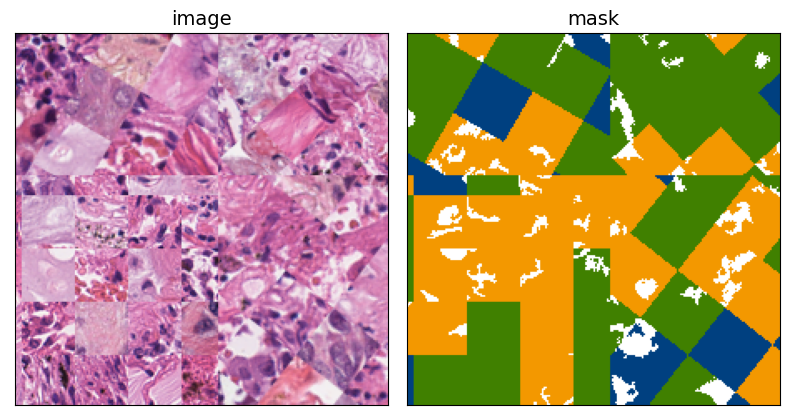

In [10]:
for i, (image, mask) in enumerate(dataset):
    print(i)
    print(image.shape, mask.shape)
    visualize(image=image, mask=mask)
    if i == 0:
        break


In [ ]:
mosaic_data = Path(f"./data/WSSS4LUAD/mosaic_{patch_num}_{patch_size}")
# mosaic_data = Path(f"./data/mosaic_onelabel")
(mosaic_data / 'img').mkdir(parents=True, exist_ok=True)
(mosaic_data / 'mask').mkdir(parents=True, exist_ok=True)
def func(indexes):
    for i in indexes:
        image, mask = dataset[i]
        image = Image.fromarray(image)
        palette = [
            0, 64, 128,  # r, g, b for Tumor
            64, 128, 0,  # r, g, b for Stroma
            243, 152, 0,  # r, g, b for Normal
            255, 255, 255,  # r, g, b for background
        ] + [0] * 252 * 3
        mask = Image.fromarray(np.uint8(mask), mode='P')
        mask.putpalette(palette)
        image.save(mosaic_data / 'img' / f'{patch_num}_{patch_size}_{i}.png')
        mask.save(mosaic_data / 'mask' / f'{patch_num}_{patch_size}_{i}.png')
        # image.save(mosaic_data / 'img' / f'onelabel_{i}.png')
        # mask.save(mosaic_data / 'mask' / f'onelabel_{i}.png')
def print_error(value):
    print("error: ", value)

In [ ]:
from multiprocessing import Process
process_list = []
num_processors = 12
for i in range(num_processors):
    p = Process(target=func,args=(range(i, len(dataset), num_processors),))
    p.start()
    process_list.append(p)

for i in process_list:
    p.join()